In [1]:
import sys
from glob import glob
from os import path as osp
from datetime import datetime
from tqdm import tqdm
from skimage import io, transform
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt
from statistics import mean
# torch imports
import torch
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader

# root path of project
from os import path as osp
import sys

# get root directory
import re
reg = '^.*/AquaPose'
project_root = re.findall(reg, osp.dirname(osp.abspath(sys.argv[0])))[0]
sys.path.append(project_root)

from lib.dataset.PoseDataset import PoseDataset
from lib.dataset.CycleDataset import CycleDataset

from lib.models.keypoint_rcnn import get_resnet50_pretrained_model

# utils
from lib.utils.slack_notifications import slack_message
from lib.utils.select_gpu import select_best_gpu
from lib.utils.rmsd import kabsch_rmsd, kabsch_rotate, kabsch_weighted_rmsd, centroid, centroid_weighted, rmsd, rmsd_weighted, kabsch

from lib.eval.pck import pck

# references import
# source: https://github.com/pytorch/vision/tree/master/references/detection
from references.engine import train_one_epoch, evaluate
from references.utils import collate_fn

from references.transforms import RandomHorizontalFlip

from lib.matching.matching import *
from lib.utils.visual_utils import *

## Model

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
cpu = torch.device('cpu')
print(device)
print(cpu)

weight_dir = osp.join(project_root, 'weights')
weight_files = glob(osp.join(weight_dir,'*'))
model = get_resnet50_pretrained_model()
for i, f in enumerate(weight_files):
    print('{}, {}'.format(i,f))
model.load_state_dict(torch.load(weight_files[11], map_location=torch.device('cpu')))

_ = model.to(device)
_ = model.eval()

cuda:0
cpu
0, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch34-50.wth
1, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch8-50.wth
2, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch12-50.wth
3, /AquaPose/AquaPose/weights/_20-03-2020-23-25_epoch9-10_min_val_loss_10000.wth
4, /AquaPose/AquaPose/weights/_01-04-2020-17-12_epoch29-30_min_val_loss_3.673452949523926.wth
5, /AquaPose/AquaPose/weights/_16-03-2020-14-30_epoch9-10.wth
6, /AquaPose/AquaPose/weights/6_freestyle_ds_20-03-2020-10-00_epoch39-40.wth
7, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch21-50.wth
8, /AquaPose/AquaPose/weights/_16-03-2020-14-11_epoch0-10.wth
9, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch6-50.wth
10, /AquaPose/AquaPose/weights/_17-03-2020-18-01_epoch14-15.wth
11, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch18-50.wth
12, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch14-50.wth
13, /AquaPose/AquaPose/weights/_19-03-2020-07-47_epoch99-100.wth
14, /AquaPose/AquaPose/weights/_16-03-2020-

In [4]:

train_dirs = [osp.join(project_root,'data/vzf/freestyle/freestyle_1'), osp.join(project_root,'data/vzf/freestyle/freestyle_2'), osp.join(project_root,'data/vzf/freestyle/freestyle_3'), osp.join(project_root,'data/vzf/freestyle/freestyle_4')]

test_dirs = [osp.join(project_root,'data/vzf/freestyle/freestyle_5')] 

train_datasets = [PoseDataset([dir], train = False, cache_predictions=True) for dir in train_dirs]
test_pose_datasets = [PoseDataset([dir], train = False, cache_predictions=True) for dir in test_dirs]
test_cycle_datasets = [CycleDataset([dir], cache_predictions=True, max_dist=100) for dir in test_dirs]

anchor_dataset = PoseDataset([osp.join(project_root,'data/vzf/freestyle/freestyle_1')], train=False, cache_predictions=True)
anchor_ids = [x for x in range(17,81,1)]
anchor_dataset = torch.utils.data.Subset(anchor_dataset, anchor_ids)

#anchor_dataset = PoseDataset([osp.join(project_root,'data/vzf/freestyle/freestyle_12')], train=False, cache_predictions=True)

In [5]:
test_pose_datasets_matching = [PoseDataset([dir], train = False, cache_predictions=True) for dir in test_dirs]
test_pose_datasets_mle = [PoseDataset([dir], train = False, cache_predictions=True) for dir in test_dirs]

In [6]:
for ds in test_pose_datasets:
    ds.predict_all(model)
for ds in test_pose_datasets_matching:
    ds.predict_all(model)
for ds in test_pose_datasets_mle:
    ds.predict_all(model)


100%|██████████| 30/30 [00:04<00:00,  7.42it/s]


In [7]:
for ds in test_cycle_datasets:
    for i in tqdm(range(0,len(ds))):
        ds.predict(model, i)

100%|██████████| 543/543 [01:13<00:00,  7.37it/s]


In [8]:
img_name_to_index_list = [pd.get_image_name_to_index() for pd in test_pose_datasets] 


In [9]:
transmat = build_transmat(len(anchor_ids), probs=[0.25,0.30,0.20,0.15,0.05,0.05])
flipped_transmat = build_transmat(2, [.95,.05])

## Loop over all corresponding datasets and do matching one per one so that image names and indexes point to the correct dataset

In [10]:

for pd, pd_match, pd_mle, cd, img_name_to_index in zip(test_pose_datasets, test_pose_datasets_matching, test_pose_datasets_mle, test_cycle_datasets, img_name_to_index_list):

    # get observations, obersation likelihoods...
    obs_lik_list, observations_list, flipped_list= get_observation_likelihood(model, cd, anchor_dataset, max_stride=3, device=device)

    mls_list = []
    for obs_lik, obs, flipped_mat, seq in zip(obs_lik_list, observations_list, flipped_list, cd.sequences):

        mls = viterbi_path(np.array([1.0/len(anchor_ids)]*len(anchor_ids)), transmat, obs_lik)
        mls_list.append(mls)

        # also get most likely sequence for being flipped or not
        flipped_observed = [flipped_mat[mls[i]][i] for i in range(0, len(mls))]
        obslik_flipped = [[ .75 - (.5 * flipped_observed[i]) for i in range(0,len(mls))]]
        obslik_flipped += [[ 1 - obslik_flipped[0][i] for i in range(0,len(mls))]]
        obslik_flipped = np.array(obslik_flipped)
      

        mls_flipped = viterbi_path([.5,.5], flipped_transmat, obslik_flipped)



        # for num, _ in enumerate(obs):
        #     print('obs {}: {}'.format(num, np.array(obs_lik)[:,num]))

        for obs_id, (img, match_anchor, mle_anchor) in tqdm(enumerate(zip(range(seq[0],seq[1]), obs, mls))):
            _, target = cd[img]
            image_name = int(target['img'].split('/')[-1].split('.')[0])
            match_warped_anchor, ax = warp_anchor_on_pred(model, cd, img, anchor_dataset, match_anchor, True if mls_flipped[obs_id] else False)
            mle_warped_anchor, ax = warp_anchor_on_pred(model, cd, img, anchor_dataset, mle_anchor, True if mls_flipped[obs_id] else False)
            if image_name in img_name_to_index.keys():
                #print('{}: caching corrected pose'.format(image_name))
                pd_match.prediction_cache_corrected[img_name_to_index[image_name]] = match_warped_anchor
                pd_mle.prediction_cache_corrected[img_name_to_index[image_name]] = mle_warped_anchor
            #plt.show()

NameError: name 'obs_lik_list' is not defined

In [30]:
pose_metric = pck(test_pose_datasets)
pose_matching_metric = pck(test_pose_datasets_matching)
pose_mle_metric = pck(test_pose_datasets_mle)

pck_score = pose_metric.score_per_keypoint(model,thresholds=[x/100 for x in range(0,55,5)], corrected=False)
inversion_error =  pose_metric.inversion_errors(model, thresholds=[x/100 for x in range(0,55,5)], corrected=False)

pck_score_matching = pose_matching_metric.score_per_keypoint(model, thresholds=[x/100 for x in range(0,55,5)], corrected=True)
inversion_error_matching =  pose_matching_metric.inversion_errors(model, thresholds=[x/100 for x in range(0,55,5)], corrected=True)

pck_score_mle = pose_mle_metric.score_per_keypoint(model, thresholds=[x/100 for x in range(0,55,5)], corrected=True)
inversion_error_mle =  pose_mle_metric.inversion_errors(model, thresholds=[x/100 for x in range(0,55,5)], corrected=True)




100%|██████████| 23/23 [00:00<00:00, 50.82it/s]


In [31]:
thresholds=[x/100 for x in range(0,55,5)]

## PCK

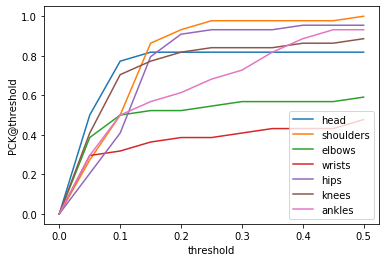

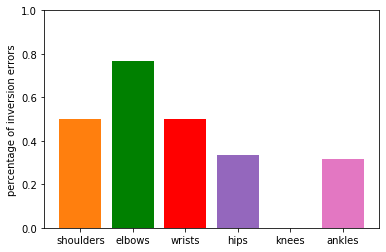

In [32]:
pck_score_merged = [0.5 * np.array([s for s in pck_score[joint]]) + 0.5 * np.array([s for s in pck_score[joint +1]]) for joint in range(1,12,2)]
inversion_error_merged = [0.5 * np.array([s for s in inversion_error[joint]]) + 0.5 * np.array([s for s in inversion_error[joint +1]]) for joint in range(1,12,2)]
plt.plot(thresholds, pck_score[0], label='head')

joint_groups = ['shoulders', 'elbows', 'wrists', 'hips', 'knees', 'ankles']
for scores, joint in zip(pck_score_merged, joint_groups):
    plt.plot(thresholds, scores, label=joint)
plt.legend()
plt.xlabel('threshold')
plt.ylabel('PCK@threshold')
plt.show()

inversion_02 = [inversion_joint[4] for inversion_joint in inversion_error_merged]
plt.bar([x for x in range(0, len(joint_groups))], inversion_02, tick_label=joint_groups, color=['#ff7f0e', 'g', 'red', '#9467bd', '#6c564b', '#e377c2'])
plt.ylim((0.0, 1.0))
plt.ylabel('percentage of inversion errors')
plt.show()

## PCK matching

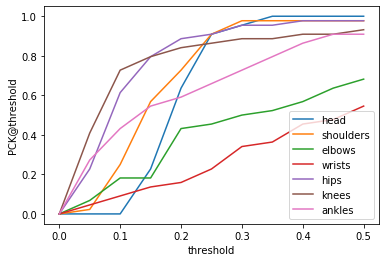

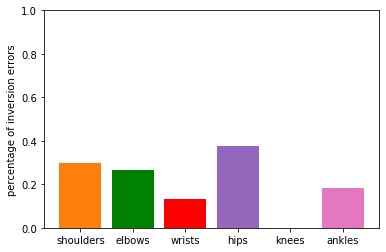

In [33]:
pck_score_merged = [0.5 * np.array([s for s in pck_score_matching[joint]]) + 0.5 * np.array([s for s in pck_score_matching[joint +1]]) for joint in range(1,12,2)]
inversion_error_merged = [0.5 * np.array([s for s in inversion_error_matching[joint]]) + 0.5 * np.array([s for s in inversion_error_matching[joint +1]]) for joint in range(1,12,2)]
plt.plot(thresholds, pck_score_matching[0], label='head')

joint_groups = ['shoulders', 'elbows', 'wrists', 'hips', 'knees', 'ankles']
for scores, joint in zip(pck_score_merged, joint_groups):
    plt.plot(thresholds, scores, label=joint)
plt.legend()
plt.xlabel('threshold')
plt.ylabel('PCK@threshold')
plt.show()

inversion_02 = [inversion_joint[4] for inversion_joint in inversion_error_merged]
plt.bar([x for x in range(0, len(joint_groups))], inversion_02, tick_label=joint_groups, color=['#ff7f0e', 'g', 'red', '#9467bd', '#6c564b', '#e377c2'])
plt.ylim((0.0, 1.0))
plt.ylabel('percentage of inversion errors')
plt.show()

In [34]:
## PCK MLE

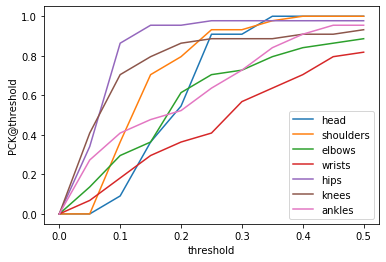

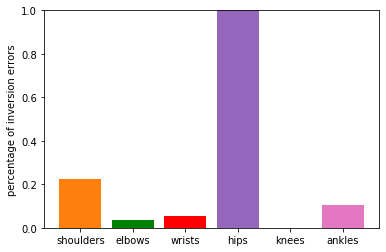

In [35]:
pck_score_merged = [0.5 * np.array([s for s in pck_score_mle[joint]]) + 0.5 * np.array([s for s in pck_score_mle[joint +1]]) for joint in range(1,12,2)]
inversion_error_merged = [0.5 * np.array([s for s in inversion_error_mle[joint]]) + 0.5 * np.array([s for s in inversion_error_mle[joint +1]]) for joint in range(1,12,2)]
plt.plot(thresholds, pck_score_mle[0], label='head')

joint_groups = ['shoulders', 'elbows', 'wrists', 'hips', 'knees', 'ankles']
for scores, joint in zip(pck_score_merged, joint_groups):
    plt.plot(thresholds, scores, label=joint)
plt.legend()
plt.xlabel('threshold')
plt.ylabel('PCK@threshold')
plt.show()

inversion_02 = [inversion_joint[4] for inversion_joint in inversion_error_merged]
plt.bar([x for x in range(0, len(joint_groups))], inversion_02, tick_label=joint_groups, color=['#ff7f0e', 'g', 'red', '#9467bd', '#6c564b', '#e377c2'])
plt.ylim((0.0, 1.0))
plt.ylabel('percentage of inversion errors')
plt.show()

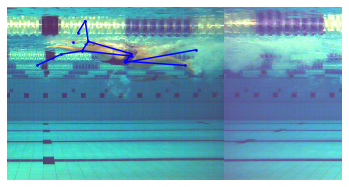

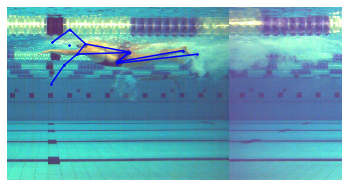

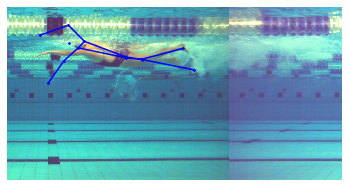

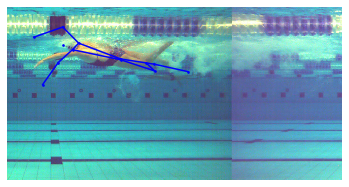

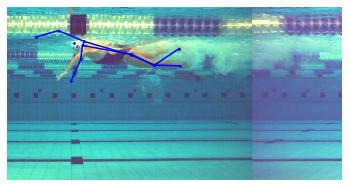

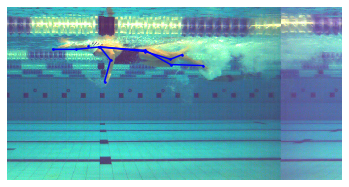

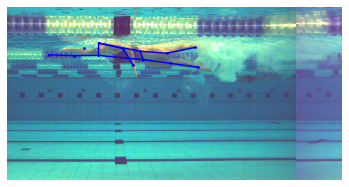

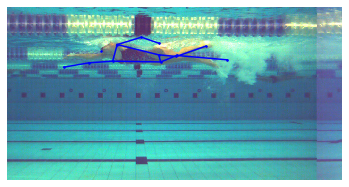

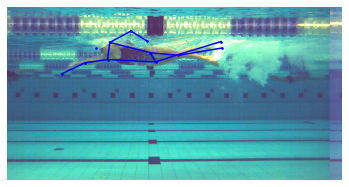

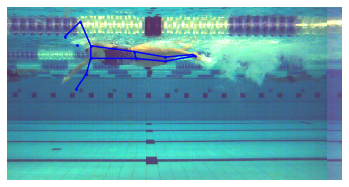

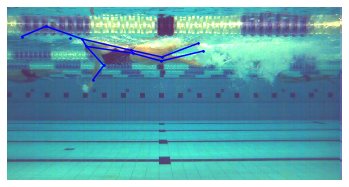

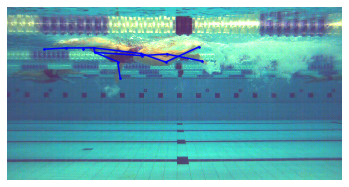

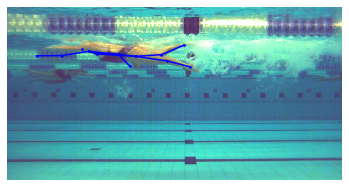

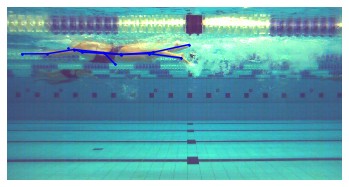

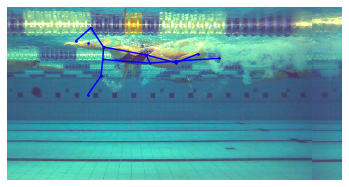

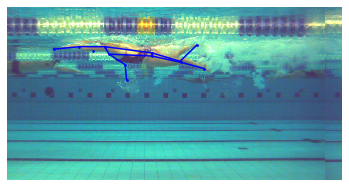

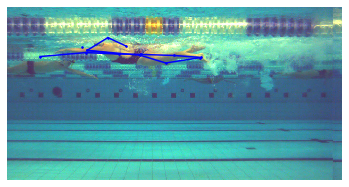

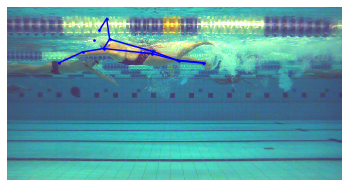

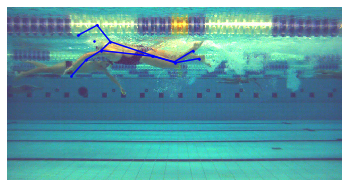

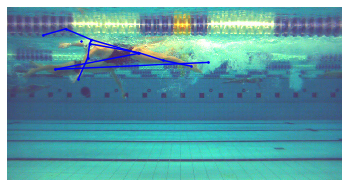

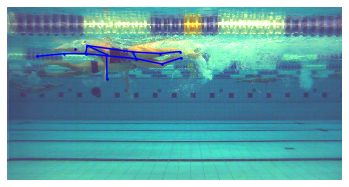

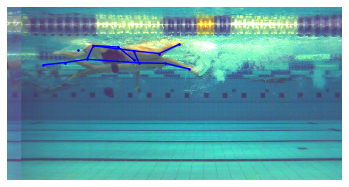

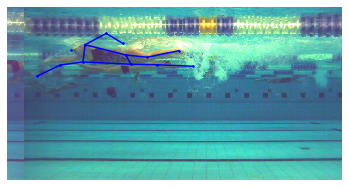

In [36]:
for ds in test_pose_datasets_mle:
    for idx, (img, target) in enumerate(ds):
        warped = ds.predict(model, idx, corrected=True)
        plot_image_with_kps_skeleton(img, [warped])